Upload your dataset (CSV with column 'password')


Saving rockyou_cleaned_large.csv to rockyou_cleaned_large (3).csv
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 841ms/step - accuracy: 0.4366 - loss: 1.0948 - val_accuracy: 0.5958 - val_loss: 1.0808
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5929 - loss: 1.0769 - val_accuracy: 0.5750 - val_loss: 1.0554
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5451 - loss: 1.0485 - val_accuracy: 0.5042 - val_loss: 1.0145
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5304 - loss: 1.0030 - val_accuracy: 0.5292 - val_loss: 0.9538
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.5362 - loss: 0.9406 - val_accuracy: 0.5375 - val_loss: 0.8699


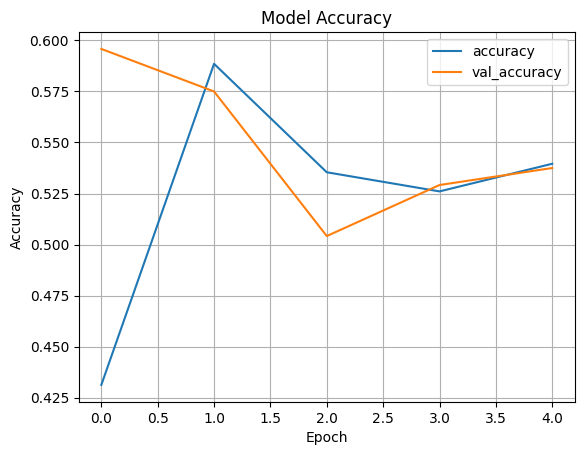


Test a password manually:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Password: MyP@ssword123
Strength: Medium (41.0%)


In [6]:
# Password Strength Analyzer using LSTM Neural Network

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import os
import re
import matplotlib.pyplot as plt

# --- Colab Setup ---
from google.colab import files

print("Upload your dataset (CSV with column 'password')")
uploaded = files.upload()
dataset_path = list(uploaded.keys())[0]

# --- Load and preprocess dataset ---
df = pd.read_csv(dataset_path)
df.dropna(inplace=True)
df = df[df['password'].apply(lambda x: isinstance(x, str))]
df = df[df['password'].str.len() >= 6]
df = df[df['password'].apply(lambda x: x.isascii())]

# Assign strength labels
def get_strength(pw):
    length = len(pw)
    if re.search(r"[A-Z]", pw) and re.search(r"[a-z]", pw) and re.search(r"[0-9]", pw) and re.search(r"[^A-Za-z0-9]", pw) and length >= 12:
        return 2  # Strong
    elif length >= 8:
        return 1  # Medium
    else:
        return 0  # Weak

df['strength'] = df['password'].apply(get_strength)

# Tokenization and padding
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['password'])
sequences = tokenizer.texts_to_sequences(df['password'])
max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = tf.keras.utils.to_categorical(df['strength'], num_classes=3)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and train model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1, batch_size=512)

# Save model and tokenizer
model.save("password_strength_model.h5")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump((tokenizer, max_len), f)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.grid(True)
plt.show()

# --- Test a single password ---
def test_password(pwd):
    sequence = tokenizer.texts_to_sequences([pwd])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    prediction = model.predict(padded)
    strength = np.argmax(prediction)
    labels = ['Weak', 'Medium', 'Strong']
    print(f"Password: {pwd}\nStrength: {labels[strength]} ({round(prediction[0][strength] * 100, 2)}%)")

# Example
print("\nTest a password manually:")
test_password("MyP@ssword123")

In [4]:
test_password("@x2s3s##ed")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Password: @x2s3s##ed
Strength: Medium (43.630001068115234%)


In [3]:
test_password("123454")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Password: 123454
Strength: Weak (54.529998779296875%)


In [7]:
%pip install gradio

In [8]:
# Load the saved model
loaded_model = tf.keras.models.load_model("password_strength_model.h5")

# Load the saved tokenizer and max_len
with open("tokenizer.pkl", "rb") as f:
    loaded_tokenizer, loaded_max_len = pickle.load(f)

In [9]:
def predict_strength(password):
    """
    Predicts the strength of a given password using the loaded model and tokenizer.

    Args:
        password: The password string to predict the strength for.

    Returns:
        A string representing the predicted strength ('Weak', 'Medium', or 'Strong').
    """
    # Convert the password string to a sequence of integers
    sequence = loaded_tokenizer.texts_to_sequences([password])

    # Pad the sequence to the maximum length
    padded_sequence = pad_sequences(sequence, maxlen=loaded_max_len, padding='post')

    # Predict the strength using the loaded model
    prediction = loaded_model.predict(padded_sequence)

    # Determine the predicted strength label
    strength_index = np.argmax(prediction)
    labels = ['Weak', 'Medium', 'Strong']
    predicted_label = labels[strength_index]

    return predicted_label

In [12]:
# Define the Gradio interface
iface = gr.Interface(
    fn=predict_strength,
    inputs=gr.Textbox(label="Enter your password"),
    outputs=gr.Textbox(label="Predicted Strength"),
    title="Password Strength Predictor",
    description="Enter a password to get its predicted strength (Weak, Medium, or Strong)."
)

# Launch the interface
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://01ff2e49ade51a5331.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
